In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def f(x):
    return 3*x**2 -4*x + 5

In [3]:
f(3.0)

20.0

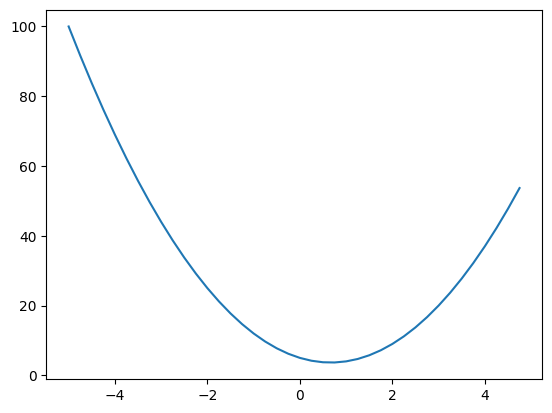

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [18]:
h = 0.00001
x = 2/3
(f(x+h) - f(x))/h

3.0000002482211127e-05

In [20]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [23]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0
d1 = a*b + c
c += h
d2 = a*b + c

print('d1 = ', d1)
print('d2 = ', d2)
print('slope:', (d2-d1)/h)

d1 =  4.0
d2 =  4.0001
slope: 0.9999999999976694


In [178]:

class Value:
    def __init__(self, data, _children = (), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out
    def __radd__(self, other):
        return self.__add__(other)
    def __sub__(self, other):
        return self + (-1*other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad*other.data
            other.grad += out.grad*self.data

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self.__mul__(other)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int and float for now"
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            self.grad += out.grad*other*self.data**(other - 1)

        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self*other**-1

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), _op='exp', label='exp(x)')

        def _backward():
            self.grad += out.grad*out.data
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        out = Value(np.tanh(x), (self,), _op='tanh', label='tanh(x)')

        def _backward():
            self.grad += (1 - out.data**2)*out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
          node._backward()



In [159]:
a= Value(2.0)
b = Value(4.0)
a*2, a+3, 3*a, 2 + a, a.exp(), a/b, a/4, a**2, a - b

(Value(data=4.0),
 Value(data=5.0),
 Value(data=6.0),
 Value(data=4.0),
 Value(data=7.38905609893065),
 Value(data=0.5),
 Value(data=0.5),
 Value(data=4.0),
 Value(data=-2.0))

In [75]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [76]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
print(a)
a + b
a*b
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
print(d)
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=2.0)
Value(data=4.0)


Value(data=-8.0)

In [77]:
d._prev, d._op

({Value(data=-6.0), Value(data=10.0)}, '+')

In [96]:
L.grad = 1
d.grad = f.data
f.grad = d.data
e.grad = d.grad
c.grad = d.grad
a.grad = b.data*e.grad; b.grad = a.data*e.grad


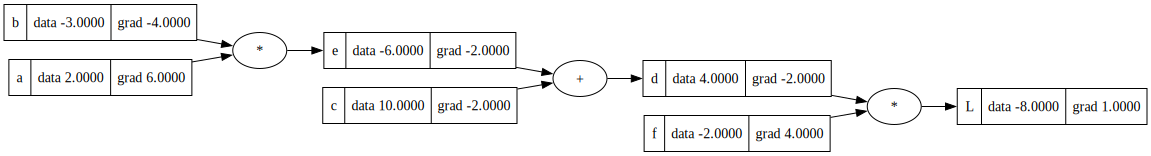

In [97]:
draw_dot(L)

In [99]:
def lol():
    h= 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0  , label='a')
    b = Value(-3.0 + h, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

lol()



-4.000000000008441


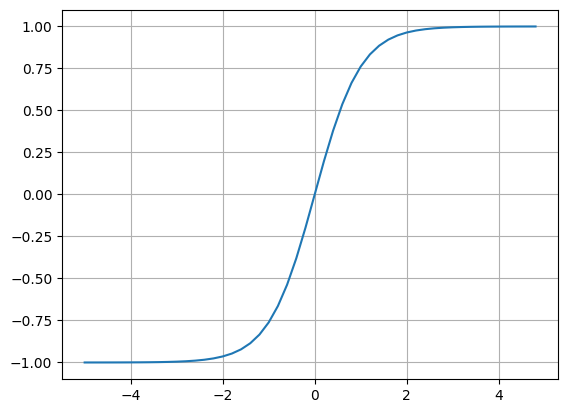

In [100]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [225]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#o = n.tanh(); o.label = 'o'
e = (2*n).exp(); e.label = 'e'
o = (e-1)/(e+1); o.label = 'o'

In [125]:
o.grad = 1.0
n.grad =  1 - (o.data)**2
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = n.grad
x2w2.grad = n.grad
w1.grad = n.grad*x1.data
w2.grad = n.grad*x2.data
x1.grad = n.grad*w1.data
x2.grad = n.grad*w2.data


In [226]:
o.backward()

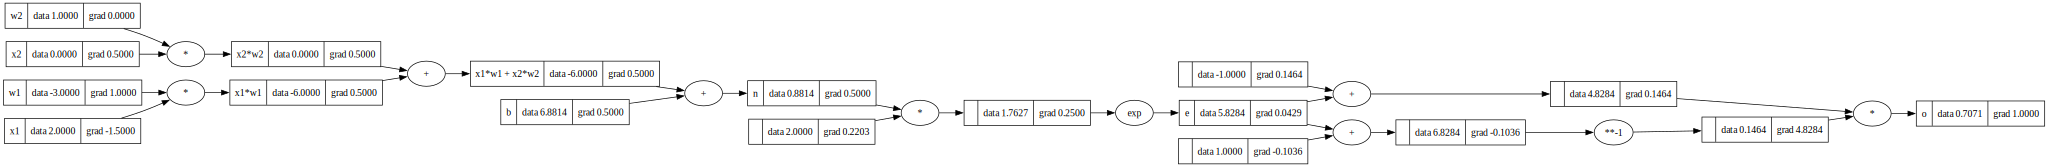

In [227]:
draw_dot(o)

In [182]:
import torch

In [183]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [188]:
import random

In [240]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [217]:
n = Layer(2,3)
x = [2.0, 3.0]
n(x)

[Value(data=-0.9965056018143943),
 Value(data=-0.7073276756896149),
 Value(data=-0.9984475458693388)]

In [241]:
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp(x)

Value(data=0.3765626416067918)

In [228]:
type(mlp(x)), type(o)

(__main__.Value, __main__.Value)

In [ ]:
draw_dot(mlp(x))

In [237]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [243]:
mlp.parameters(), len(mlp.parameters())

([Value(data=-0.14533608140735632),
  Value(data=0.03915975618834522),
  Value(data=0.10462134257484723),
  Value(data=0.9900494079111617),
  Value(data=-0.3151753874506005),
  Value(data=0.3795049397395316),
  Value(data=-0.15063414013038234),
  Value(data=-0.2014929557467564),
  Value(data=-0.24933831796907513),
  Value(data=-0.5448277312429506),
  Value(data=0.4321842266095375),
  Value(data=-0.2649486077927332),
  Value(data=0.6871502121281836),
  Value(data=0.07378145248674262),
  Value(data=0.7687388149407146),
  Value(data=0.01014744264849865),
  Value(data=0.38213224410952273),
  Value(data=-0.30802550470983414),
  Value(data=0.7277644648963726),
  Value(data=-0.917943370349726),
  Value(data=0.4484617962275732),
  Value(data=-0.9063618058204352),
  Value(data=0.45866907002636226),
  Value(data=-0.3388012776373537),
  Value(data=0.01292463812834388),
  Value(data=-0.854443133032645),
  Value(data=-0.26732740080809525),
  Value(data=0.9177503790834973),
  Value(data=0.1607275861

In [239]:
ypred = [mlp(x) for x in xs]
ypred

[Value(data=0.8894716270993092),
 Value(data=0.5630242901466622),
 Value(data=0.9255493256853365),
 Value(data=0.8181737592723245)]

In [247]:
for k in range(100):
    ypred = [mlp(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred) )

    for p in mlp.parameters():
        p.grad = 0
    loss.backward()

    for p in mlp.parameters():
        p.data += -0.01*p.grad

    print(k, loss.data)


0 0.20422260063132502
1 0.19574694512743862
2 0.18786139621590547
3 0.18051060669509955
4 0.17364559373148383
5 0.16722288864947515
6 0.16120381399187067
7 0.15555386708198193
8 0.15024219292564372
9 0.14524113224800914
10 0.14052583288429288
11 0.13607391473291974
12 0.1318651801140231
13 0.12788136272139555
14 0.12410590946512362
15 0.12052379041855571
16 0.11712133284212668
17 0.11388607588642238
18 0.11080664310090729
19 0.10787263031178015
20 0.1050745067978161
21 0.10240352799929035
22 0.09985165825236597
23 0.09741150225802064
24 0.09507624417753754
25 0.09283959340140256
26 0.09069573616979132
27 0.08863929233449502
28 0.0866652766473004
29 0.08476906404112704
30 0.08294635843980083
31 0.08119316469204144
32 0.07950576327655556
33 0.07788068746934136
34 0.07631470270247215
35 0.07480478787664266
36 0.07334811841837122
37 0.07194205089759559
38 0.07058410904301392
39 0.06927197101136046
40 0.0680034577832535
41 0.06677652257263832
42 0.06558924114945361
43 0.06443980298621046
44

In [248]:
ypred_upd = [mlp(x) for x in xs]
ypred_upd

[Value(data=0.9464299899540882),
 Value(data=-0.9381386850881617),
 Value(data=-0.8898395259618807),
 Value(data=0.8891219313468064)]